# Банки — Анализ оттока клиентов

**Задача:**

Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

# Описание датасета

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Колонки:**


    userid — идентификатор пользователя,
    score — баллы кредитного скоринга,
    City — город,
    Gender — пол,
    Age — возраст,
    Objects — количество объектов в собственности,
    Balance — баланс на счёте,
    Products — количество продуктов, которыми пользуется клиент,
    CreditCard — есть ли кредитная карта,
    Loyalty — был ли активнен клиент последнее время,
    estimated_salary — заработная плата клиента,
    Churn — ушёл или нет.

   

##  Шаг. Откроем файл с данными и изучим общую информацию. 

In [ ]:
#импортируем библиотеки 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
!pip install phik
import phik
from phik import report
from phik.report import plot_correlation_matrix
warnings.filterwarnings("ignore")

In [ ]:
#откроем таблицу
data = pd.read_csv('/datasets/bank_dataset.csv')
# Посмотрим данные
data.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


В датасете 12 колонок и 10 тысяч строк. Активность клиента и наличие кредитной карты  в системе 1/0. Пол клиента принимает значения М и Ж.

## Шаг. Предобработка данных
### Проверка типов данных

In [ ]:
#изучим информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
#Приведем название колонок к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Привели название колонок к нижнему регистру. Все типы данных соответсвуют данным. Видно, что есть есть пропуски в колонке Баланс. Изучим-какую долю занимают пропуски. 

### Проверка на пропуски

In [ ]:
#выведем доли пропусков в значениях 
print(round(data.isna().sum()/len(data)*100,1))

userid               0.0
score                0.0
city                 0.0
gender               0.0
age                  0.0
objects              0.0
balance             36.2
products             0.0
creditcard           0.0
loyalty              0.0
estimated_salary     0.0
churn                0.0
dtype: float64


In [ ]:
#проверим на наличие явных дубликатов
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


Отметим, что количество дубликатов - 0, доля пропусков в Балансе составляет 36.2%. Заполнение данных приведет к искажению, поэтому оставим все как есть.

### Изучение данных на выбросы

In [ ]:
# Изучим средние значения и отклонения признаков
data.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


 Максимальное количество **баллов кредитного скоринга** - 850, минимальное - 350,
 Минимальный **возраст** -18, а максимальный - 92, средний возраст - 39, 75% клиетов -44,
 Минимальное **количество объектов в собственности** - 0, а максимальное - 10,
 Минимальный **баланс на счёте** составляет-3769, Максимальный баланс -250 898,
 Минимальное **количество продуктов, которыми пользуется клиент** -1, максимальное -4,
 Минимальная **заработная плата клиента**-12, максимальная - 199992,
Видим, что клиенты бывают разные, разного возраста, с разным числом собственности, кредитной историей и заработной платой.

## Шаг. Проведем исследовательский анализ данных

### Изучение структуры датасета

In [ ]:
#выведем названия колонок
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [ ]:
#создадим словарь с русским названием колонок
rus_columns = ['id пользователя', 'кредитный скоринг', 'город', 'пол', 'возраст', 'объекты в собственности',
              'баланс', 'продукты банка', 'наличие кредитной карты', 'активность клиента', 'оценка зарплаты',
              'отток']
data_columns_dict = dict(zip(data.columns, rus_columns))
data_columns_dict

{'userid': 'id пользователя',
 'score': 'кредитный скоринг',
 'city': 'город',
 'gender': 'пол',
 'age': 'возраст',
 'objects': 'объекты в собственности',
 'balance': 'баланс',
 'products': 'продукты банка',
 'creditcard': 'наличие кредитной карты',
 'loyalty': 'активность клиента',
 'estimated_salary': 'оценка зарплаты',
 'churn': 'отток'}

### Изучение распределения признаков

In [ ]:
#добавим функцию подписывающую значения над столбчатой диаграммой
def autolabel(rects, labels=None, height_factor=1.01):
    """
    функция создающая подписи над столбчатыми диаграмами
    """
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),

                ha='center', va='bottom')

In [ ]:
#Изучим уникальные значения городов
data['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

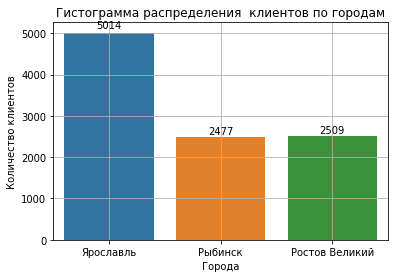

In [ ]:
#Построим гистограмму распределения  по городам
plots = sns.countplot(x = data['city'], data = data)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Гистограмма распределения  клиентов по городам')
plt.xlabel( 'Города')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();

В датасете 3 города: Ярославль, Рыбинск, Ростов Великий. В Ярославле - 5014 клиентов, в Рыбинске - 2509 клиентов, в Ростове Великом - 2477.

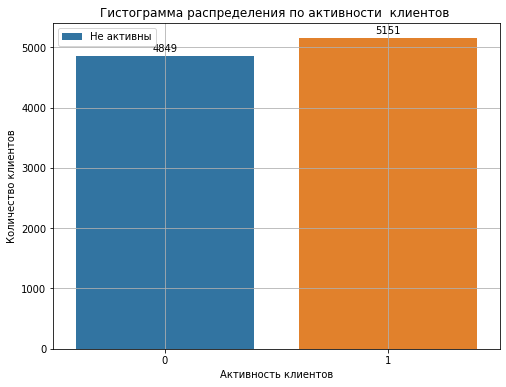

In [ ]:
#Построим гистограмму распределения  по активности клиентов
plt.figure(figsize=(8, 6))
plots = sns.countplot(x = data['loyalty'], data = data)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Гистограмма распределения по активности  клиентов ')
plt.xlabel( 'Активность клиентов')
plt.ylabel('Количество клиентов')
plt.grid(True)
plt.legend(['Не активны', 'Активны'])

plt.show();

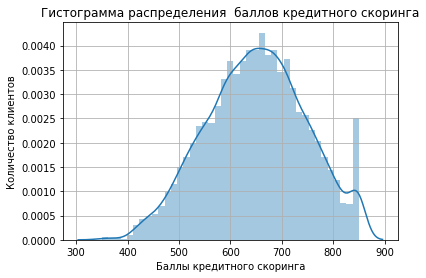

In [ ]:
#Построим гистограмму распределения  баллов кредитного скоринга
sns.distplot(data['score'])
plt.title('Гистограмма распределения  баллов кредитного скоринга')
plt.xlabel( 'Баллы кредитного скоринга')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();

По **Гистограмме распределения  баллов кредитного скоринга** видно, что большинство клиентов имеют значения баллов кредитного скоринга от 600 до 700, минимум-350, на максимуме значений 850 выброс значений.

In [ ]:
#Изучим число уникальных значений идентификаторов пользователей
data['userid'].nunique()

10000

Из 10000 строк датасета, 10000 уникальных пользователей.

In [ ]:
#выведем число мужчин и женщин в таблице
data['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

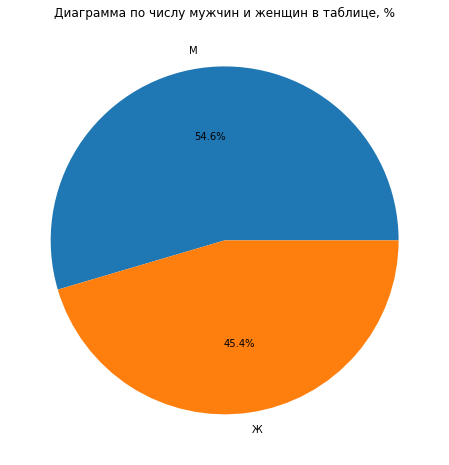

In [ ]:
#Выведем круговую диаграмму по числу мужчин и женщин в таблице
category = data['gender'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Диаграмма по числу мужчин и женщин в таблице, %');

В датасете 5457 (54,6%) клиентов мужского пола и 4543(45,4%) - женского, почти поровну.

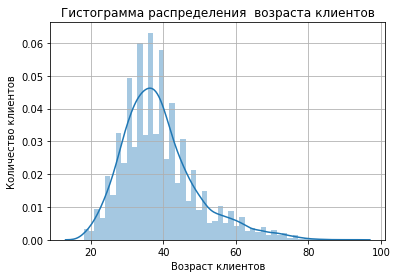

In [ ]:
#Построим гистограмму распределения возраста клиентов
#plt.hist(data['age'], bins=20)
sns.distplot(data['age'])
plt.title('Гистограмма распределения  возраста клиентов')
plt.xlabel( 'Возраст клиентов')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();

По **Гистограмме распределения  возраста клиентов** отметим, что большое количество клиентов от 25 до 50, с пиком где-то от 32 до 40 лет.

In [ ]:
#Выведем число объектов
data['objects'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

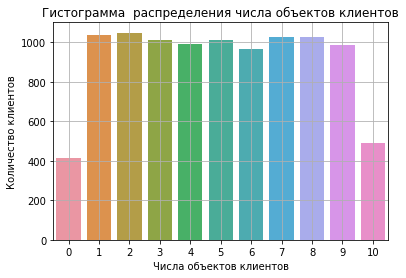

In [ ]:
#Построим гистограмму распределения числа объектов клиентов
sns.countplot(x = data['objects'], data = data)
plt.title('Гистограмма  распределения числа объектов клиентов')
plt.xlabel( 'Числа объектов клиентов')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();


По **Гистограмме  распределения числа объектов клиентов** видно, что число клиентов распределилось приблизительно одинаково в диапазоне от 1 до 9 объектов, и в два раза меньше клиентов с числом объектов - 0 и 10.

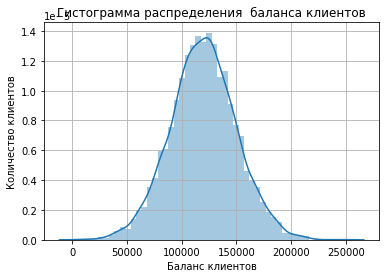

In [ ]:
#Построим гистограмму распределения баланса клиентов
sns.distplot(data['balance'])
plt.title('Гистограмма распределения  баланса клиентов')
plt.xlabel( 'Баланс клиентов')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();

По **Гистограмме распределения  баланса клиентов** отметим, что основная масса клиентов имееет баланс от 51 000 до 180 000, с пиком от 100 000 до 150 000.

In [ ]:
#выведем число клиентов по продуктам банка
data['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

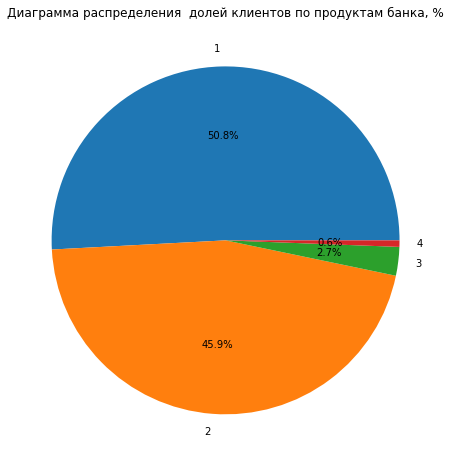

In [ ]:
#Выведем круговую диаграмму доли клиентов по продуктам банка
category = data['products'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Диаграмма распределения  долей клиентов по продуктам банка, %');

По **Диаграмме распределения долей клиентов по продуктам банка** видно, что больше половины клиентов - 50,8% (5084) имеют только один продукт банка, 45,9% (4590) - два продукта банка, 2,7% (266) - три продукта банка, 0,6% (60) - четыре продукта банка.

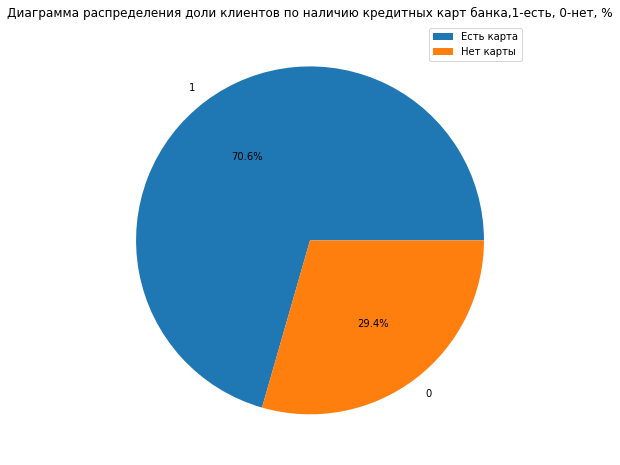

In [ ]:
#Выведем круговую диаграмму доли клиентов по наличию кредитных карт
category = data['creditcard'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Диаграмма распределения доли клиентов по наличию кредитных карт банка,1-есть, 0-нет, %')
plt.legend(['Есть карта', 'Нет карты'])
plt.show();

По **Диаграмме распределения доли клиентов по наличию кредитных карт банка** видно, что у 70,6% - есть, у 29,4%-нет.

In [ ]:
#Выведем число активных и не активных клиентов
data['loyalty'].value_counts()


1    5151
0    4849
Name: loyalty, dtype: int64

Видно, что почти поровну клиентов активных и не активных. Активных немного больше - 5151, не активных - 4849.

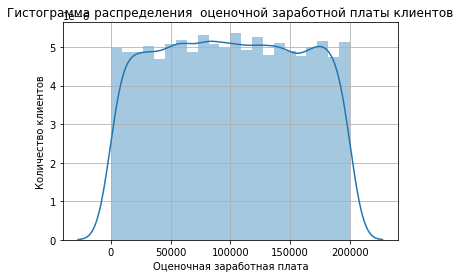

In [ ]:
#Построим гистограмму распределения оценочной заработной платы клиентов
sns.distplot(data['estimated_salary'])
plt.title('Гистограмма распределения  оценочной заработной платы клиентов')
plt.xlabel( 'Оценочная заработная плата')
plt.ylabel('Количество клиентов')
plt.grid(True)

plt.show();

По **Гистограмме распределения  оценочной заработной платы клиентов** видно, что число клиентов приблизительно одинаково распределяется для всех значений заработной платы.

In [ ]:
#Выведем число  клиентов, которые уходят или нет
data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

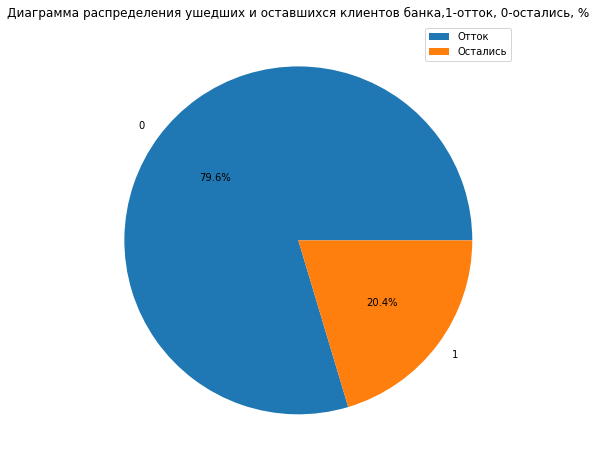

In [ ]:
#Выведем круговую диаграмму распределения ушедших и оставшихся клиентов
category = data['churn'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Диаграмма распределения ушедших и оставшихся клиентов банка,1-отток, 0-остались, %')
plt.legend(['Отток', 'Остались']);

Уходят 2037 (20,4%) клиентов, осталось - 7963 (79,6%).

## Шаг. Решений основной задачи - анализ оттока клиентов

### Исследовать долю оттока для каждого из признаков

In [ ]:
#выведем число пропусков в колонке баланс
data['balance'].isna().sum()

3617

In [ ]:
#выведем число пропусков в колонке баланс в зависимости от того ушел клиент или нет
data.groupby('churn')['balance'].apply(lambda x: x.isna().sum())

churn
0    3117
1     500
Name: balance, dtype: int64

Видно, что из числа пропусков в колонке баланс 500 человек приходится на клиентов,которые ушли, и 3117 -которые остались

In [ ]:
#выведем значения числа клиентов по наличию кредитных карт с пропусками в балансе
data.groupby('creditcard')['balance'].apply(lambda x: x.isna().sum())

creditcard
0    1025
1    2592
Name: balance, dtype: int64

In [ ]:
#вывдем число клиентов по наличию кредитных карт
data['creditcard'].value_counts()

1    7055
0    2945
Name: creditcard, dtype: int64

Пропуски в балансе  чаще встречаются у клиентов с кредитной картой.

In [ ]:
#выведем число клиентов по наличию продуктов банка с пропуском в балансе
data.groupby('products')['balance'].apply(lambda x: x.isna().sum())

products
1     905
2    2600
3      98
4      14
Name: balance, dtype: int64

In [ ]:
#выведем число клиентов по наличию продуктов банка
data['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

Видим, большинство пропусков в балансе для клиентов, пользующихся 2 продуктами банка. Возможно, речь идет о клиентах, использующих только кредитные продукты и не держащих собственных средств на дебетовом счете. В таком случае у клиента как раз могут быть два продукта: например, ипотека и кредитая карта.

В любом случае, без уточняющей информации мы не можем заполнять или удалять эти пропуски.

In [ ]:
#сохраним таблицу клиетов ушедших
data_churn = data.query('churn==1')

In [ ]:
#сохраним таблицу клиетов оставшихся
data_not_churn = data.query('churn==0')

In [ ]:
#посмотрим процент пропусков в балансе у ушедших клиентов
print('Процент пропусков в балансе у ушедших клиентов:', round(data_churn['balance'].isna().sum()\
                                                      /len(data_churn['balance'])*100, 4), '%')

Процент пропусков в балансе у ушедших клиентов: 24.5459 %


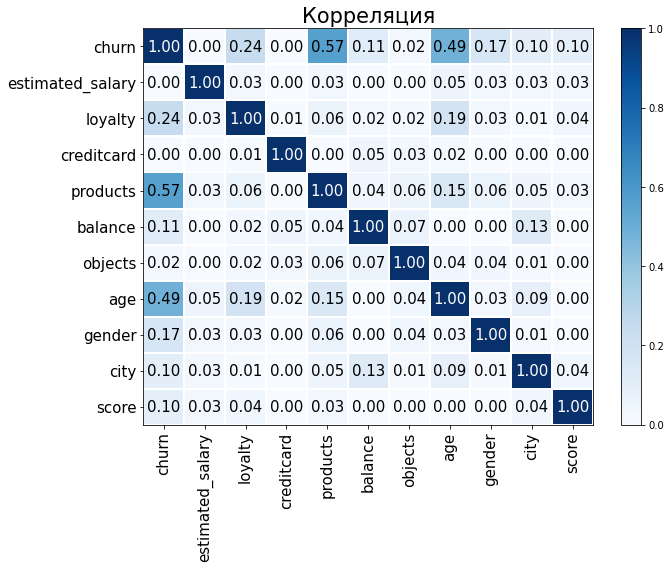

In [ ]:
#постоим матрицу корреляции
data_columns = ['score',   'age', 'objects', 'balance','products', 'creditcard', 'loyalty',
                'estimated_salary', 'churn']
phik_data = data.drop('userid', axis=1).phik_matrix(interval_cols=data_columns)
plot_correlation_matrix(phik_data.values, 
                        x_labels=phik_data.columns, 
                        y_labels=phik_data.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()
    

**На тепловой карте выше представлена матрица значимости** одних параметров по отношению к другим. Видно, что отток клиентов зависит от количества продуктов у клиента банка (0,57),  возраста (0,49). Слабее выражена значимость активности клиента (0,24)

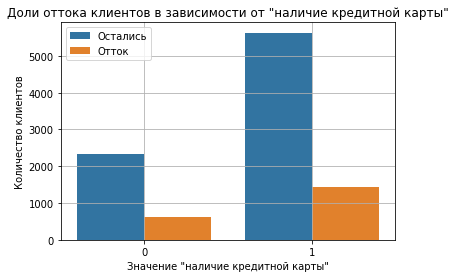

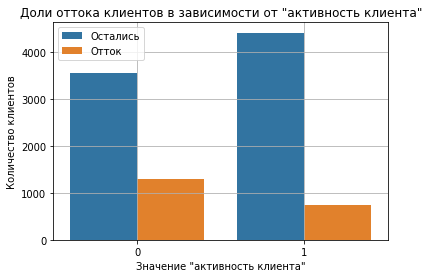

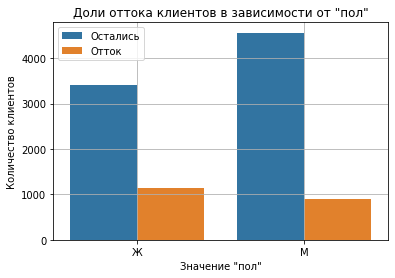

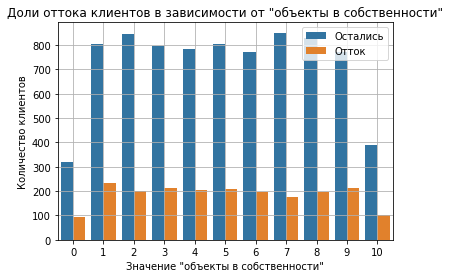

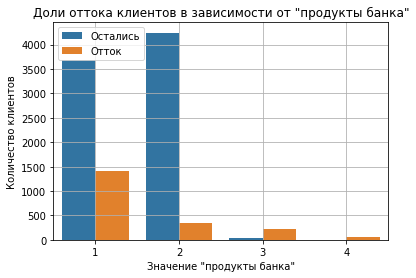

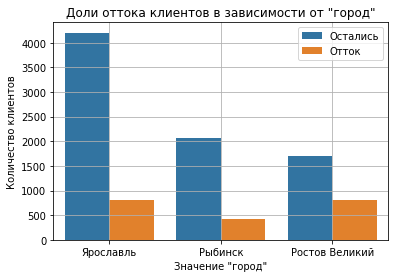

In [ ]:
#Бинарные и дискретные признаки визуализируем методом "countplot"
for col in data[['creditcard', 'loyalty', 'gender','objects', 'products', 'city']].columns:
    ax = sns.countplot(x = col, hue = 'churn', data = data)
   
    plt.title(f'Доли оттока клиентов в зависимости от "{data_columns_dict[col]}"' )
    plt.ylabel('Количество клиентов')
    plt.xlabel(f'Значение "{data_columns_dict[col]}"')
    plt.legend(['Остались', 'Отток'])
    plt.grid(True)
    
    plt.show()


По гистограмме доли оттока клиентов в зависимости от **кредитной карты** видно, что клиенты у которых кредитная карта этого банка имеется, уходят чаще, чем которые не имееют ее.

По гистограмме доли оттока клиентов в зависимости от **loyalty-был ли клиент активен** отметим, что те, кто не был активен последнее время, чаще уходят из клиентов банка.

По гистограмме доли оттока клиентов в зависимости от **Гендерного признака** видно, что женщины уходят чаще, чем мужчины.

По гистограмме доли оттока клиентов в зависимости от **колчества объектов** заметим, что те, у кого количество собственности от 1 до 9 реже уходят, большая доля оттока клиентов с нулевым количеством собственности, а также с количеством-10.

По гистограмме доли оттока клиентов в зависимости от **количества продуктов банка** видно, что клиенты у которых 3-4 продукта ушло больше, чем осталось, но большее количество уходят клиентов, у которых 1 продукт банка. Самые постоянные клиенты с 2 продуктами, у них отток меньше всего.

По гистограмме доли оттока клиентов в зависимости от **города** отметим, что больше всего отток происходит в городе Ростов Великий,  у остальных меньшая доля клиентов уходит.

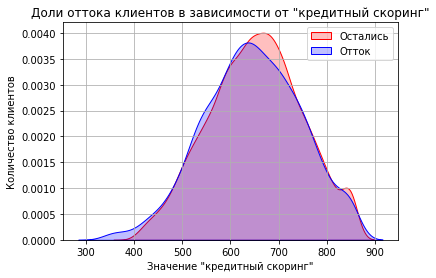

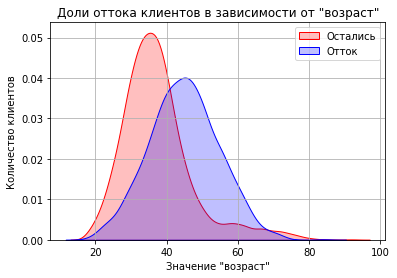

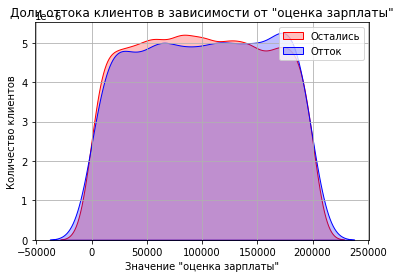

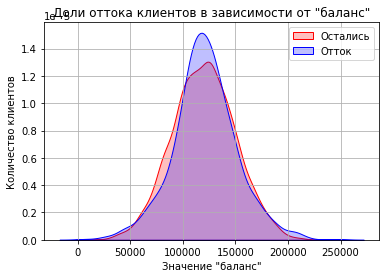

In [ ]:
# Непрерывные признаки визуализируем методом "kdeplot"
for col in data[['score', 'age', 'estimated_salary', 'balance']].columns:
    sns.kdeplot(data.query('churn == 0')[col], shade=True, color="r")
    sns.kdeplot(data.query('churn == 1')[col], shade=True, color="b")
    plt.title(f'Доли оттока клиентов в зависимости от "{data_columns_dict[col]}"' )
    plt.ylabel('Количество клиентов')
    plt.xlabel(f'Значение "{data_columns_dict[col]}"')
    plt.legend(['Остались', 'Отток'])
    plt.grid(True)
    
    plt.show();

In [ ]:
#выведем основные значения для таблицы ушедших клиентов
data_churn.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,2.037000e+03,2037.000000,2037.000000,2037.000000,1537.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0
mean,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531,1.0
std,7.269262e+04,100.321503,9.761562,2.936106,30555.192802,0.801521,0.458776,0.480358,57912.418071,0.0
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,1.0
25%,1.567010e+07,578.000000,38.000000,2.000000,103700.690000,1.000000,0.000000,0.000000,51907.720000,1.0
50%,1.573170e+07,646.000000,45.000000,5.000000,119948.090000,1.000000,1.000000,0.000000,102460.840000,1.0
75%,1.579583e+07,716.000000,51.000000,8.000000,137986.580000,2.000000,1.000000,1.000000,152422.910000,1.0
max,1.585839e+07,850.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199808.100000,1.0


In [ ]:
#выведем основные значения для таблицы оставшихся клиентов
data_not_churn.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,7.963000e+03,7963.000000,7963.000000,7963.000000,4846.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.0
mean,1.573390e+07,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772,0.0
std,7.174423e+04,95.653837,10.125363,2.880658,29944.927372,0.509536,0.455101,0.497045,57405.586966,0.0
min,1.560844e+07,405.000000,18.000000,0.000000,14262.800000,1.000000,0.000000,0.000000,90.070000,0.0
25%,1.567155e+07,585.000000,31.000000,3.000000,99118.230000,1.000000,0.000000,0.000000,50783.490000,0.0
50%,1.573428e+07,653.000000,36.000000,5.000000,119791.215000,2.000000,1.000000,1.000000,99645.040000,0.0
75%,1.579609e+07,718.000000,41.000000,7.000000,139747.397500,2.000000,1.000000,1.000000,148609.955000,0.0
max,1.585843e+07,850.000000,92.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,199992.480000,0.0


По графику  оттока клиентов в зависимости от **score-баллов кредитного скоринга** видно, что чаще всего клиенты уходят с меньшим числом баллов, особенно от 300 до 450, такая зависимость видна с пиком где-то около 646.

По графику  оттока клиентов в зависимости от **возраста** отметим, что чаще всего остаются клиенты от 18 до 50, с пиком в 36 лет. А у клиентов которые ушли возраст смешен до 70 где то, с пиком 45 лет.

По графику  оттока клиентов в зависимости от **заработной платы** видно, что отток больше у клиентов с заработной платой  от 150 000 до 200 000

По графику  оттока клиентов в зависимости от **баланса** заметим, что уходят чаще клиенты, у которых на счету от 100 000 до 150 000, с пиком в 119948


### Выделение портретов клиентов, которые склонны уходить из банка

In [ ]:
#выведем основные значения для таблицы ушедших клиентов женщин
data_churn.query('gender == "Ж" ').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.139000e+03,1139.000000,1139.000000,1139.000000,849.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.0
mean,1.573150e+07,646.883231,44.784899,4.933275,119449.625713,1.510975,0.697981,0.363477,102948.986093,1.0
std,7.283991e+04,99.339831,9.900218,2.956469,31326.640791,0.822900,0.459335,0.481212,57879.508706,0.0
min,1.560895e+07,350.000000,19.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,91.750000,1.0
25%,1.567027e+07,582.500000,38.000000,2.000000,102277.520000,1.000000,0.000000,0.000000,53147.320000,1.0
50%,1.572897e+07,648.000000,45.000000,5.000000,118994.840000,1.000000,1.000000,0.000000,106663.460000,1.0
75%,1.579356e+07,716.000000,51.000000,7.500000,137464.040000,2.000000,1.000000,1.000000,153241.645000,1.0
max,1.585839e+07,850.000000,84.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199808.100000,1.0


In [ ]:
#выведем основные значения для таблицы ушедших клиентов мужчин
data_churn.query('gender == "М" ').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,8.980000e+02,898.000000,898.000000,898.000000,688.000000,898.000000,898.000000,898.000000,898.000000,898.0
mean,1.573442e+07,643.408686,44.905345,4.932071,122347.910465,1.429844,0.700445,0.357461,99584.287272,1.0
std,7.251292e+04,101.575235,9.587882,2.911718,29519.583119,0.771626,0.458318,0.479519,57931.720284,0.0
min,1.560844e+07,350.000000,18.000000,0.000000,24043.450000,1.000000,0.000000,0.000000,11.580000,1.0
25%,1.567017e+07,572.000000,38.000000,2.000000,105328.160000,1.000000,0.000000,0.000000,51246.875000,1.0
50%,1.573352e+07,643.500000,45.000000,5.000000,120814.125000,1.000000,1.000000,0.000000,98083.205000,1.0
75%,1.579785e+07,716.750000,51.000000,8.000000,139323.400000,2.000000,1.000000,1.000000,150633.190000,1.0
max,1.585836e+07,850.000000,71.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199693.840000,1.0


По таблицам  ушедших женщин и мужчин клиентов видно, что число ушедших женщин клиентов - 1139, мужчин - 898. 50% значчения возраста и среднее не сильно отличается у мужчин и женщин - 45 лет. Также и с балансом приблизительно 120 000. У женщин несколько больше значчения 50% и среднего заработной платы, чем у мужчин на 4-8 тыс.руб.

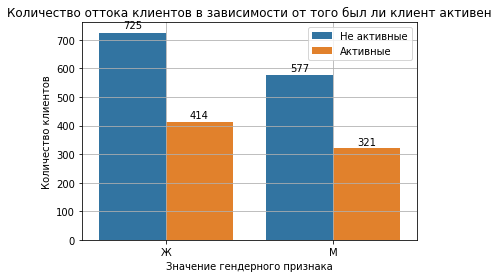

In [ ]:
#Выведем столбчатую диаграмму Количества оттока клиентов в зависимости от пола и от того был ли клиент активен
ax = sns.countplot(x = 'gender', hue = 'loyalty', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от того был ли клиент активен' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['Не активные', 'Активные'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших неактивных мужчин клиентов
print('Количество ушедших неактивных мужчин клиентов: ', data_churn.query('gender == "М" and loyalty==0 ')\
      ['userid'].nunique())

Количество ушедших неактивных мужчин клиентов:  577


In [ ]:
#посмотрим процент ушедших неактивных мужчин клиентов
print('Процент ушедших неактивных мужчин клиентов:', round(data_churn.query('gender == "М" and loyalty==0 ')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших неактивных мужчин клиентов: 64.2539 %


In [ ]:
#выведем число ушедших неактивных женщин клиентов
print('Количество ушедших неактивных женщин клиентов: ', data_churn.query('gender == "Ж" and loyalty==0 ')\
      ['userid'].nunique())

Количество ушедших неактивных женщин клиентов:  725


In [ ]:
#посмотрим процент ушедших неактивных женщин клиентов
print('Процент ушедших неактивных женщин клиентов:', round(data_churn.query('gender == "Ж" and loyalty==0 ')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших неактивных женщин клиентов: 63.6523 %


По графику **Количество оттока клиентов в зависимости от того был ли клиент активен** видно, что число ушедших неактивных клиентов больше ушедших и активных, также и тут видим подтверждение, что  женщины уходят немного чаще, чем  мужчины клиенты.

Посчитав число и процент неактивных мужчин и женщин получили:

        - Количество ушедших неактивных мужчин клиентов:  577 (64.2539 %)
        - Количество ушедших неактивных женщин клиентов:  725 (63.6523 %)
        

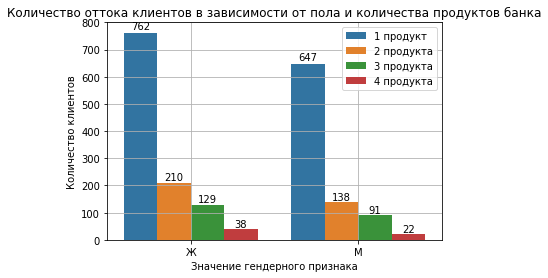

In [ ]:
#выведем график зависимости Количества оттока клиентов в зависимости от пола и количества продуктов банка
ax = sns.countplot(x = 'gender', hue = 'products', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от пола и количества продуктов банка' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['1 продукт', '2 продукта','3 продукта','4 продукта'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов с 1 продуктом
print('Количество ушедших женщин клиентов с 1 продуктом: ', data_churn.query('gender == "Ж" and products==1 ')\
      ['userid'].nunique())

Количество ушедших женщин клиентов с 1 продуктом:  762


In [ ]:
#посмотрим процент ушедших неактивных женщин клиентов с 1 продуктом
print('Процент ушедших женщин клиентов с 1 продуктом:', round(data_churn.query('gender == "Ж" and products==1 ')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов с 1 продуктом: 66.9008 %


In [ ]:
#выведем число ушедших мужчин клиентов с 1 продуктом
print('Количество ушедших мужчин клиентов с 1 продуктом: ', data_churn.query('gender == "М" and products==1 ')\
      ['userid'].nunique())

Количество ушедших мужчин клиентов с 1 продуктом:  647


In [ ]:
#посмотрим процент ушедших неактивных мужчин клиентов с 1 продуктом
print('Процент ушедших мужчин клиентов с 1 продуктом:', round(data_churn.query('gender == "М" and products==1 ')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов с 1 продуктом: 72.049 %


In [ ]:
#выведем число ушедших неактивных женщин клиентов с 1 продуктом
print('Количество ушедших неактивных женщин клиентов с 1 продуктом: ', data_churn.\
      query('gender == "Ж" and products==1 and loyalty==0')['userid'].nunique())

Количество ушедших неактивных женщин клиентов с 1 продуктом:  499


In [ ]:
#посмотрим процент ушедших неактивных женщин клиентов с 1 продуктом
print('Процент ушедших неактивных женщин клиентов с 1 продуктом:', round(data_churn.\
                                        query('gender == "Ж" and products==1 and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших неактивных женщин клиентов с 1 продуктом: 43.8104 %


In [ ]:
#выведем число ушедших мужчин клиентов с 1 продуктом
print('Количество ушедших неактивных мужчин клиентов с 1 продуктом: ', data_churn.\
      query('gender == "М" and products==1 and loyalty==0')['userid'].nunique())

Количество ушедших неактивных мужчин клиентов с 1 продуктом:  425


In [ ]:
#посмотрим процент ушедших неактивных мужчин клиентов с 1 продуктом
print('Процент ушедших  неактивных мужчин клиентов с 1 продуктом:', round(data_churn.\
                                        query('gender == "М" and products==1 and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших  неактивных мужчин клиентов с 1 продуктом: 47.3274 %


По графику зависимости **Количества оттока клиентов в зависимости от пола и количества продуктов банка** видно, что у женщин значения выше по всем продуктам. Также больше всего отток и у женщин и мужчин  с 1 продуктом. 

Посчитав число и процент  мужчин и женщин с 1 продуктом получили:

    - Количество ушедших женщин клиентов с 1 продуктом:  762 (66.9008 %)
    - Количество ушедших мужчин клиентов с 1 продуктом:  647 (72.049 %)
  

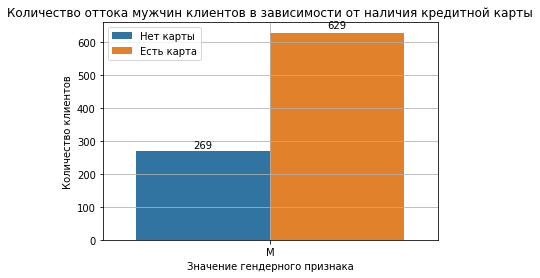

In [ ]:
#выведем график зависимости Количество оттока мужчин клиентов в зависимости от наличия кредитной карты банка
ax = sns.countplot(x = 'gender', hue = 'creditcard', data = data_churn.query('gender == "М" '))
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока мужчин клиентов в зависимости от наличия кредитной карты' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['Нет карты', 'Есть карта'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших мужчин клиентов с кредитной картой
print('Количество ушедших мужчин клиентов с кредитной картой: ', data_churn.query('gender == "М" and creditcard==1 ')\
      ['userid'].nunique())

Количество ушедших мужчин клиентов с кредитной картой:  629


In [ ]:
#посмотрим процент ушедших неактивных мужчин клиентов с кредитной картой
print('Процент ушедших мужчин клиентов с кредитной картой:', round(data_churn.query('gender == "М" and creditcard==1')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов с кредитной картой: 70.0445 %


По **графику зависимости Количество оттока мужчин клиентов в зависимости от наличия кредитной карты банка** видим, что 
количество ушедших мужчин клиентов с кредитной картой:  629, что составляет 70.0445 %
     

In [ ]:
#выведем число ушедших неактивных мужчин клиентов с кредитной картой
print('Количество ушедших неактивных мужчин клиентов с кредитной картой: ', data_churn.\
      query('gender == "М" and creditcard==1 and loyalty==0 ')['userid'].nunique())

Количество ушедших неактивных мужчин клиентов с кредитной картой:  419


In [ ]:
#посмотрим процент ушедших неактивных мужчин клиентов с кредитной картой
print('Процент ушедших неактивных мужчин клиентов с кредитной картой:', round(data_churn.\
                                        query('gender == "М" and creditcard==1 and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших неактивных мужчин клиентов с кредитной картой: 46.6592 %


Посчитали, что Количество ушедших **неактивных мужчин клиентов с кредитной картой**:  419 и это 46.6592 % от общего числа мужчин клиентов.

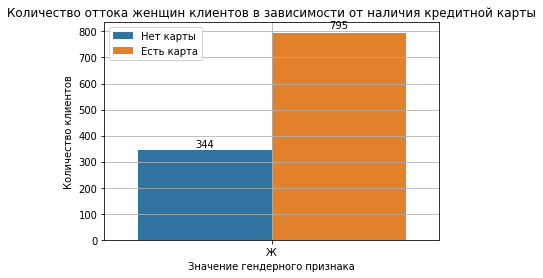

In [ ]:
#выведем график зависимости Количество оттока женщин клиентов в зависимости от наличия кредитной карты банка
ax = sns.countplot(x = 'gender', hue = 'creditcard', data = data_churn.query('gender == "Ж" '))
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока женщин клиентов в зависимости от наличия кредитной карты' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['Нет карты', 'Есть карта'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов с кредитной картой
print('Количество ушедших женщин клиентов с кредитной картой: ', data_churn.query('gender == "Ж" and creditcard==1 ')\
      ['userid'].nunique())

Количество ушедших женщин клиентов с кредитной картой:  795


In [ ]:
#посмотрим процент ушедших женщин клиентов с кредитной картой
print('Процент ушедших женщин клиентов с кредитной картой:', round(data_churn.query('gender == "Ж" and creditcard==1 ')\
                                                           ['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов с кредитной картой: 69.7981 %


По **графику зависимости Количество оттока женщин клиентов в зависимости от наличия кредитной карты банка** отмечаем, что Количество ушедших женщин клиентов с кредитной картой:  795, что составляет 69.7981 %.


In [ ]:
#выведем число ушедших неактивных женщин клиентов с кредитной картой
print('Количество ушедших неактивных женщин клиентов с кредитной картой: ', data_churn.\
      query('gender == "Ж" and creditcard==1 and loyalty==0 ')['userid'].nunique())

Количество ушедших неактивных женщин клиентов с кредитной картой:  523


In [ ]:
#посмотрим процент ушедших неактивных женщин клиентов с кредитной картой
print('Процент ушедших неактивных женщин клиентов с кредитной картой:', round(data_churn.\
                                        query('gender == "Ж" and creditcard==1 and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших неактивных женщин клиентов с кредитной картой: 45.9175 %


Посчитали, что Количество ушедших **неактивных женщин клиентов с кредитной картой**:  523 и это 45.9175 % от общего числа женщин клиентов.

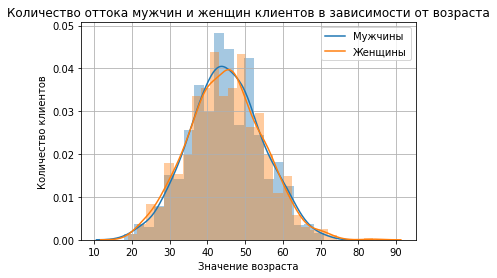

In [ ]:
#выведем график зависимости Количество оттока клиентов в зависимости от от возраста
sns.distplot(data_churn.query('gender == "М" ')['age'])
sns.distplot(data_churn.query('gender == "Ж" ')['age'])
plt.title('Количество оттока мужчин и женщин клиентов в зависимости от возраста' )
plt.legend(['Мужчины', 'Женщины'])
plt.ylabel('Количество клиентов')
plt.xlabel('Значение возраста')
plt.grid(True)
    
plt.show()

In [ ]:
#посчитаем границу выбросов и квинтили, max и min для возраста мужчин
q1 = round(data_churn.query('gender == "М" ')['age'].quantile(0.25),)
q2 = round(data_churn.query('gender == "М" ')['age'].quantile(0.50),)
q3 = round(data_churn.query('gender == "М" ')['age'].quantile(0.75),)
release_max_age = round(q3+1.5*(q3-q1),)
release_min_age = round(q3-1.5*(q3-q1),)
age_min = data_churn.query('gender == "М" ')['age'].min()
age_max = data_churn.query('gender == "М" ')['age'].max()

print('Максимальный возраст ушедших мужчин клиентов :', age_max)
print('Минимальный возраст ушедших мужчин клиентов:', age_min)
print('Верхняя граница значений возраста ушедших мужчин клиентов:', release_max_age)
print('Нижняя граница значений возраста ушедших мужчин клиентов:', release_min_age)
print('25% от значений возраста ушедших мужчин клиентов:', q1)
print('50% от значений возраста ушедших мужчин клиентов:',  q2)
print('75% от значений возраста ушедших мужчин клиентов:',  q3)

Максимальный возраст ушедших мужчин клиентов : 71
Минимальный возраст ушедших мужчин клиентов: 18
Верхняя граница значений возраста ушедших мужчин клиентов: 70
Нижняя граница значений возраста ушедших мужчин клиентов: 32
25% от значений возраста ушедших мужчин клиентов: 38
50% от значений возраста ушедших мужчин клиентов: 45
75% от значений возраста ушедших мужчин клиентов: 51


In [ ]:
#посчитаем границу выбросов и квинтили, max и min для возраста женщин
q1 = round(data_churn.query('gender == "Ж" ')['age'].quantile(0.25),)
q2 = round(data_churn.query('gender == "Ж" ')['age'].quantile(0.50),)
q3 = round(data_churn.query('gender == "Ж" ')['age'].quantile(0.75),)
release_max_age = round(q3+1.5*(q3-q1),)
release_min_age = round(q3-1.5*(q3-q1),)
age_min = data_churn.query('gender == "Ж" ')['age'].min()
age_max = data_churn.query('gender == "Ж" ')['age'].max()

print('Максимальный возраст ушедших женщин клиентов :', age_max)
print('Минимальный возраст ушедших женщин клиентов:', age_min)
print('Верхняя граница значений возраста ушедших женщин клиентов:', release_max_age)
print('Нижняя граница значений возраста ушедших клиентов:', release_min_age)
print('25% от значений возраста ушедших женщин клиентов:', q1)
print('50% от значений возраста ушедших женщин клиентов:',  q2)
print('75% от значений возраста ушедших женщин клиентов:',  q3)

Максимальный возраст ушедших женщин клиентов : 84
Минимальный возраст ушедших женщин клиентов: 19
Верхняя граница значений возраста ушедших женщин клиентов: 70
Нижняя граница значений возраста ушедших клиентов: 32
25% от значений возраста ушедших женщин клиентов: 38
50% от значений возраста ушедших женщин клиентов: 45
75% от значений возраста ушедших женщин клиентов: 51


По таблицы особых значений мы уже видели, что 50% для значения возраста у мужчин и женщин одинаково и составляет 50 лет, еще раз в этом убедились при расчете и отмечаем, что одинакова Верхняя граница значений возраста ушедших и для мужчин и для женщин клиентов: 70 лет, Нижняя граница значений возраста ушедших и для мужчин и для женщин клиентов: 32 лет. Поэтому категоризацию сделать можно общую не зависимо от пола. За границы категорий, судя по графику и расчету возьмем значения от минимального возраста до 25% квинтиля, от 25% квинтиля и до 75% квинтиля, и от 75% квинтиля и до максимального значения возраста.

In [ ]:
def categoraze_age(age):
    """
    Функция, которая распределяет значение столбца по 3 категориям 
    используя квинтиль 25%, 50%, 75%, максимальное и минимальное значения.
    """
 
    try:
        if age_min<= age < q1:
            return '{}_{}'.format(age_min, q1)
        if q1 <= age < q3:
            return '{}_{}'.format(q1, q3)
        elif q3 <= age <= age_max:
            return '{}_{}'.format(q3, age_max)
    except:
        pass

In [ ]:
#проверим распределение числа клиентов в категориях возраста
data_churn['age_categorize'] = data_churn['age'].apply(categoraze_age)
data_churn['age_categorize'].value_counts()

38_51    1012
51_84     563
19_38     460
Name: age_categorize, dtype: int64

Получили три категории возраста:

    - 19_38 содержит 460 человек 
    - 38_51 состаляет 1012 человек
    - 51_84 включает 563 человек

Рассмотрим подробнее на графике это распределение  с разделением по полу

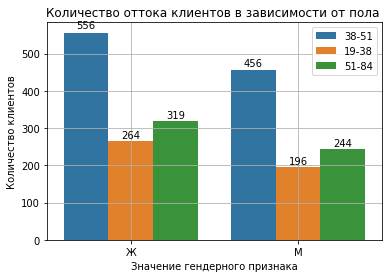

In [ ]:
#выведем график зависимости Количества оттока клиентов в зависимости от пола 
sns.countplot(x = 'gender', hue = 'age_categorize', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от пола ' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['38-51','19-38', '51-84'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов в возрасте 38-51
print('Количество ушедших женщин клиентов в возрасте 38-51: ',data_churn.query('gender == "Ж" and age_categorize=="38_51"')\
      ['userid'].nunique())

Количество ушедших женщин клиентов в возрасте 38-51:  556


In [ ]:
#посмотрим процент ушедших женщин клиентов  в возрасте 38-51
print('Процент ушедших женщин клиентов в возрасте 38-51:', round(data_churn.\
                                    query('gender == "Ж" and age_categorize=="38_51"')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов в возрасте 38-51: 48.8147 %


In [ ]:
#выведем число ушедших мужчин клиентов в возрасте 38-51
print('Количество ушедших мужчин клиентов в возрасте 38-51: ',data_churn.query('gender == "М" and age_categorize=="38_51"')\
      ['userid'].nunique())

Количество ушедших мужчин клиентов в возрасте 38-51:  456


In [ ]:
#посмотрим процент ушедших  мужчин клиентов  в возрасте 38-51
print('Процент ушедших мужчин клиентов в возрасте 38-51:', round(data_churn.\
                                    query('gender == "М" and age_categorize=="38_51"')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов в возрасте 38-51: 50.7795 %


По  **графику зависимости Количества оттока клиентов в зависимости от пола** видим, что 

    - Количество ушедших женщин клиентов в возрасте 38-51:  556 это (48.8147 %), 
    - Количество ушедших мужчин клиентов в возрасте 38-51:  456 (50.7795 %)


In [ ]:
#выведем число ушедших неактивных клиентов в возрасте 38-51
print('Количество ушедших неактивных клиентов в возрасте 38-51: ',data_churn.query('loyalty==0 and age_categorize=="38_51"')\
      ['userid'].nunique())

Количество ушедших неактивных клиентов в возрасте 38-51:  655


In [ ]:
#посмотрим процент ушедших нееактивных клиентов  в возрасте 38-51
print('Процент ушедших неактивных клиентов в возрасте 38-51:', round(data_churn.\
                                    query('loyalty==0 and age_categorize=="38_51"')['userid'].nunique()
                                        /len(data_churn['userid'])*100, 4), '%')

Процент ушедших неактивных клиентов в возрасте 38-51: 32.1551 %


In [ ]:
#выведем число ушедших клиентов в возрасте 38-51 с одним продуктом
print('Количество ушедших  клиентов с одним продуктом в возрасте 38-51: ',data_churn.\
      query('products==1 and age_categorize=="38_51"')['userid'].nunique())

Количество ушедших  клиентов с одним продуктом в возрасте 38-51:  699


In [ ]:
#посмотрим процент ушедших клиентов  с одним продуктом в возрасте 38-51
print('Процент ушедших клиентов с одним продуктом в возрасте 38-51:', round(data_churn.\
                                    query(' products==1 and age_categorize=="38_51"')['userid'].nunique()
                                        /len(data_churn['userid'])*100, 4), '%')

Процент ушедших клиентов с одним продуктом в возрасте 38-51: 34.3152 %


Проделав дополнительные вычисления после категоризации по возрасту получили, что

    - Количество ушедших неактивных клиентов в возрасте 38-51:  655 (32.1551 %)
    - Количество ушедших  клиентов с одним продуктом в возрасте 38-51:  699 (34.3152 %)

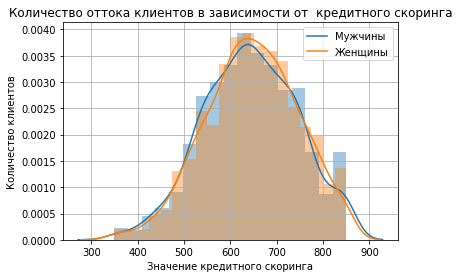

In [ ]:
#выведем график зависимости Количество оттока мужчин клиентов в зависимости от кредитного скоринга
sns.distplot(data_churn.query('gender == "М" ')['score'])
sns.distplot(data_churn.query('gender == "Ж" ')['score'])
plt.title('Количество оттока клиентов в зависимости от  кредитного скоринга' )
plt.legend(['Мужчины', 'Женщины'])
plt.ylabel('Количество клиентов')
plt.xlabel('Значение кредитного скоринга')
plt.grid(True)
    
plt.show()

По **графику зависимости Количество оттока мужчин клиентов в зависимости от кредитного скоринга** отметим, что у ушедших  мужчин и женщин не сильно отличаются значения кредитного скоринга, поэтому разделим для удобства на несколько групп для подробного рассмотрения.

In [ ]:
#посчитаем границу выбросов и квинтили, max и min для кредитного скоринга
q1 = round(data_churn['score'].quantile(0.25),)
q2 = round(data_churn['score'].quantile(0.50),)
q3 = round(data_churn['score'].quantile(0.75),)
release_max_age = round(q3+1.5*(q3-q1),)
release_min_age = round(q3-1.5*(q3-q1),)
age_min = data_churn['score'].min()
age_max = data_churn['score'].max()

print('Максимальный кредитный скоринг ушедших клиентов :', age_max)
print('Минимальный кредитный скоринг ушедших клиентов:', age_min)
print('Верхняя граница значений кредитный скоринг ушедших клиентов:', release_max_age)
print('Нижняя граница значений кредитный скоринг ушедших клиентов:', release_min_age)
print('25% от значений кредитный скоринг ушедших клиентов:', q1)
print('50% от значений кредитный скоринг ушедших клиентов:',  q2)
print('75% от значений кредитный скоринг ушедших клиентов:',  q3)

Максимальный кредитный скоринг ушедших клиентов : 850
Минимальный кредитный скоринг ушедших клиентов: 350
Верхняя граница значений кредитный скоринг ушедших клиентов: 923
Нижняя граница значений кредитный скоринг ушедших клиентов: 509
25% от значений кредитный скоринг ушедших клиентов: 578
50% от значений кредитный скоринг ушедших клиентов: 646
75% от значений кредитный скоринг ушедших клиентов: 716


In [ ]:
#создадим столбец с категориями по кредитному скорингу
data_churn['score_categorize'] = data_churn['score'].apply(categoraze_age)
data_churn['score_categorize'].value_counts()

578_716    1016
716_850     513
350_578     508
Name: score_categorize, dtype: int64

Разделили на три категории от минимума до 25% квинтиля значений кредитного скоринга, от 25% до 75% квинтилей (куда приходится большинство ушеедших клиентов и по графику), и с 75% до максимума значений кредитного скоринга.
Получилось 3 группы со значением кредитного скоринга:

    - 350_578 включает 508 человек
    - 578_716 содержит 1016 человек
    - 716_850 входит 513 человек

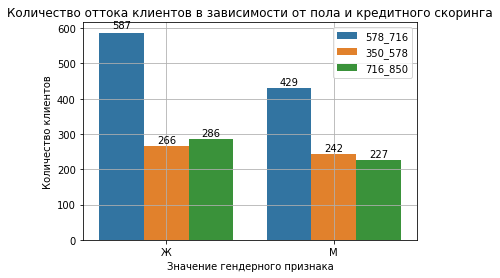

In [ ]:
#выведем график зависимости Количества оттока клиентов в зависимости от пола и кредитного скоринга
sns.countplot(x = 'gender', hue = 'score_categorize', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от пола и кредитного скоринга' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['578_716','350_578', '716_850'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов с кредитным скорингом 578-716
print('Количество ушедших женщин клиентов кредитным скорингом 578-716: ',data_churn.\
      query('gender == "Ж" and score_categorize=="578_716"')['userid'].nunique())

Количество ушедших женщин клиентов кредитным скорингом 578-716:  587


In [ ]:
#посмотрим процент ушедших женщин клиентов  с кредитным скорингом 578-716
print('Процент ушедших женщин клиентов с кредитным скорингом 578-716:', round(data_churn.\
                                    query('gender == "Ж" and score_categorize=="578_716"')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов с кредитным скорингом 578-716: 51.5364 %


In [ ]:
#выведем число ушедших мужчин клиентов с кредитным скорингом 578-716
print('Количество ушедших мужчин клиентов с кредитным скорингом 578-716: ',data_churn.\
      query('gender == "М" and score_categorize=="578_716"')['userid'].nunique())

Количество ушедших мужчин клиентов с кредитным скорингом 578-716:  429


In [ ]:
#посмотрим процент ушедших  мужчин клиентов  с кредитным скорингом 578-716
print('Процент ушедших мужчин клиентов с кредитным скорингом 578-716:', round(data_churn.\
                                    query('gender == "М" and score_categorize=="578_716"')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов с кредитным скорингом 578-716: 47.7728 %


По **графику зависимости Количества оттока клиентов в зависимости от пола и кредитного скоринга** отметим, что Количество ушедших женщин клиентов кредитным скорингом 578-716:  587 (51.5364 %), Количество ушедших мужчин клиентов с кредитным скорингом 578-716:  429 (47.7728 %).

In [ ]:
#выведем число ушедших  клиентов с кредитным скорингом 578-716 и  с кредитной картой
print('Количество ушедших клиентов  с кредитной картой и с кредитным скорингом 578-716: ',data_churn.\
      query('creditcard==1 and score_categorize=="578_716"')['userid'].nunique())

Количество ушедших клиентов  с кредитной картой и с кредитным скорингом 578-716:  719


In [ ]:
#посмотрим процент ушедших  клиентов с кредитной картой с кредитным скорингом 578-716
print('Процент ушедших  клиентов с кредитной картой и кредитным скорингом 578-716:', round(data_churn.\
                                    query('creditcard==1 and score_categorize=="578_716"')['userid'].nunique()
                                        /len(data_churn['userid'])*100, 4), '%')

Процент ушедших  клиентов с кредитной картой и кредитным скорингом 578-716: 35.297 %


Произведя дополнительные вычисления, получили Количество ушедших клиентов  с кредитной картой и с кредитным скорингом 578-716:  719 (35.297 %)

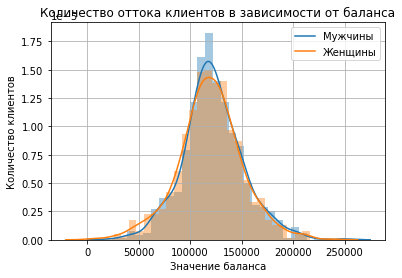

In [ ]:
#выведем график зависимости Количество оттока  клиентов в зависимости от баланса и от пола
sns.distplot(data_churn.query('gender == "М" ')['balance'])
sns.distplot(data_churn.query('gender == "Ж" ')['balance'])
plt.title('Количество оттока клиентов в зависимости от баланса' )
plt.legend(['Мужчины', 'Женщины'])
plt.ylabel('Количество клиентов')
plt.xlabel('Значение баланса')
plt.grid(True)
    
plt.show()

По **график зависимости Количество оттока  клиентов в зависимости от баланса и от пола** отметим, что у ушедших  мужчин и женщин несильно отличаются значения баланса, поэтому разделим для удобства на несколько групп для подробного рассмотрения.

In [ ]:
#посчитаем границу выбросов и квинтили, max и min для баланса
q1 = round(data_churn['balance'].quantile(0.25),)
q2 = round(data_churn['balance'].quantile(0.50),)
q3 = round(data_churn['balance'].quantile(0.75),)
release_max_age = round(q3+1.5*(q3-q1),)
release_min_age = round(q3-1.5*(q3-q1),)
age_min = data_churn['balance'].min()
age_max = data_churn['balance'].max()

print('Максимальный баланс ушедших клиентов :', age_max)
print('Минимальный баланс ушедших клиентов:', age_min)
print('Верхняя граница значений баланса ушедших клиентов:', release_max_age)
print('Нижняя граница значений баланса ушедших клиентов:', release_min_age)
print('25% от значений баланса ушедших клиентов:', q1)
print('50% от значений баланса ушедших клиентов:',  q2)
print('75% от значений баланса ушедших клиентов:',  q3)

Максимальный баланс ушедших клиентов : 250898.09
Минимальный баланс ушедших клиентов: 3768.69
Верхняя граница значений баланса ушедших клиентов: 189416
Нижняя граница значений баланса ушедших клиентов: 86558
25% от значений баланса ушедших клиентов: 103701
50% от значений баланса ушедших клиентов: 119948
75% от значений баланса ушедших клиентов: 137987


In [ ]:
#создадим столбец с категориями по балансу
data_churn['balance_categorize'] = data_churn['balance'].apply(categoraze_age)
data_churn['balance_categorize'].value_counts()

103701_137987       768
3768.69_103701      385
137987_250898.09    384
Name: balance_categorize, dtype: int64

Разделили на три категории от минимума до 25% квинтиля значений баланса, от 25% до 75% квинтилей (куда приходится большинство ушеедших клиентов и по графику), и с 75% до максимума значений баланса.
Получилось 3 группы со значением баланса:

    - 3768.69_103701 имеют 385 человек
    - 103701_137987 имеют 768 человек
    - 137987_250898.09 имеют 384 человек

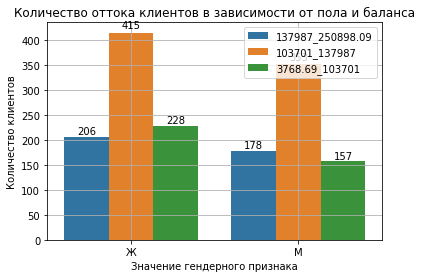

In [ ]:
#выведем график зависимости Количества оттока клиентов в зависимости от пола и  категории баланса
sns.countplot(x = 'gender', hue = 'balance_categorize', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от пола и баланса' )
plt.ylabel('Количество клиентов')
plt.xlabel('Значение гендерного признака')
plt.legend(['137987_250898.09','103701_137987', '3768.69_103701'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов с балансом 103701_137987
print('Количество ушедших женщин клиентов с балансом 103701-137987: ',data_churn.\
      query('gender == "Ж" and balance_categorize=="103701_137987"')['userid'].nunique())

Количество ушедших женщин клиентов с балансом 103701-137987:  415


In [ ]:
#посмотрим процент ушедших женщин клиентов  с балансом 103701_137987
print('Процент ушедших женщин клиентов с балансом 103701-137987:', round(data_churn.\
                                    query('gender == "Ж" and balance_categorize=="103701_137987"')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов с балансом 103701-137987: 36.4355 %


In [ ]:
#выведем число ушедших мужчин клиентов с балансом 103701_137987
print('Количество ушедших мужчин клиентов с балансом 103701-137987: ',data_churn.\
      query('gender == "М" and balance_categorize=="103701_137987"')['userid'].nunique())

Количество ушедших мужчин клиентов с балансом 103701-137987:  353


In [ ]:
#посмотрим процент ушедших  мужчин клиентов  с балансом 103701_137987
print('Процент ушедших мужчин клиентов сс балансом 103701_137987:', round(data_churn.\
                                    query('gender == "М" and balance_categorize=="103701_137987"')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов сс балансом 103701_137987: 39.3096 %


По **графику зависимости Количества оттока клиентов в зависимости от пола и  категории баланса** видно, что

    - Количество ушедших женщин клиентов с балансом 103701-137987:  415 (36.4355 %).
    - Количество ушедших мужчин клиентов с балансом 103701-137987:  353 (39.3096 %)

In [ ]:
#выведем число ушедших клиентов с кредитной картой и с балансом 103701_137987
print('Количество ушедших клиентов с кредитной картой и с балансом 103701-137987: ',data_churn.\
      query('creditcard==1 and balance_categorize=="103701_137987"')['userid'].nunique())

Количество ушедших клиентов с кредитной картой и с балансом 103701-137987:  551


In [ ]:
#посмотрим процент ушедших  клиентов  с кредитной картой и балансом 103701-137987
print('Процент ушедших  клиентов  с кредитной картой и с балансом 103701-137987:', round(data_churn.\
                                    query('creditcard==1 and balance_categorize=="103701_137987"')['userid'].nunique()
                                        /len(data_churn['userid'])*100, 4), '%')

Процент ушедших  клиентов  с кредитной картой и с балансом 103701-137987: 27.0496 %


Проведя дополнительные вычисления получаем, что:
    
    - Количество ушедших клиентов с кредитной картой и с балансом 103701-137987:  551 (27.0496 %)

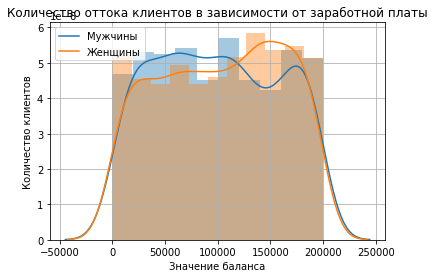

In [ ]:
#выведем график зависимости Количество оттока клиентов в зависимости от пола и заработной платы
sns.distplot(data_churn.query('gender == "М" ')['estimated_salary'])
sns.distplot(data_churn.query('gender == "Ж" ')['estimated_salary'])
plt.title('Количество оттока клиентов в зависимости от заработной платы' )
plt.legend(['Мужчины', 'Женщины'])
plt.ylabel('Количество клиентов')
plt.xlabel('Значение баланса')
plt.grid(True)
    
plt.show()


In [ ]:
#посмотрим процент ушедших  мужчин клиентов  с заработной платой 20 000-120 000
print('Процент ушедших мужчин клиентов с заработной платой 20 000-120 000:', round(data_churn.\
                                    query('gender == "М" and 20000<=estimated_salary<=120000')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов с заработной платой 20 000-120 000: 52.3385 %


In [ ]:
#выведем число ушедших мужчин клиентов с заработной платой 20 000 - 120 000
print('Количество ушедших мужчин клиентов с заработной платой 20 000 - 120 000: ',data_churn.\
      query('gender == "М" and 20000<=estimated_salary<=120000')['userid'].nunique())

Количество ушедших мужчин клиентов с заработной платой 20 000 - 120 000:  470


In [ ]:
#посмотрим процент ушедших женщин клиентов  с заработной платой 110 000 - 200 000
print('Процент ушедших  женщин клиентов с заработной платой 110 000 - 200 0000:', round(data_churn.\
                             query('gender == "Ж" and 110000<=estimated_salary<=200000')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших  женщин клиентов с заработной платой 110 000 - 200 0000: 48.3758 %


In [ ]:
#выведем число ушедших женщин клиентов с заработной платой 110 000 - 200 000
print('Количество ушедших женщин клиентов с заработной платой 110 000 - 200 000: ',data_churn.\
      query('gender == "Ж" and 110000<=estimated_salary<=200000')['userid'].nunique())

Количество ушедших женщин клиентов с заработной платой 110 000 - 200 000:  551


По **графику зависимости Количество оттока клиентов в зависимости от пола и заработной платы** видно, что больше мужчин клиентов уходят больше с заработной платой приблизительно от 20 000 до 120 000. А женщины уходят чаще с 110 000 до 200 000.

    - Количество ушедших мужчин клиентов с заработной платой 20 000 - 120 000:  470 (52.3385 %). 
    - Количество ушедших женщин клиентов с заработной платой 110 000 - 200 000:  551 (48.3758 %)
    


In [ ]:
#посмотрим процент ушедших женщин клиентов  с заработной платой 0 - 110 000
print('Процент ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 0000:', round(data_churn.\
                              query('gender == "Ж" and 0<=estimated_salary<=110000 and creditcard==1')['userid'].nunique()
                                        /len(data_churn.query('gender == "Ж"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 0000: 26.8657 %


In [ ]:
#выведем число ушедших женщин клиентов с заработной платой 110 000 - 200 000
print('Количество ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 000: ',data_churn.\
      query('gender == "Ж" and 0<=estimated_salary<=110000 and creditcard==1')['userid'].nunique())

Количество ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 000:  424


In [ ]:
#посмотрим процент ушедших мужчин клиентов  с заработной платой 0 - 110 000
print('Процент ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 0000:', round(data_churn.\
                              query('gender == "М" and 0<=estimated_salary<=110000 and creditcard==1')['userid'].nunique()
                                        /len(data_churn.query('gender == "М"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 0000: 39.6437 %


In [ ]:
#выведем число ушедших мужчин клиентов с заработной платой 110 000 - 200 000
print('Количество ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 000: ',data_churn.\
      query('gender == "М" and 0<=estimated_salary<=110000 and creditcard==1')['userid'].nunique())

Количество ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 000:  356


In [ ]:
#посмотрим процент ушедших неактивных клиентов  с заработной платой 110 000 - 200 000
print('Процент ушедших неактивных клиентов с заработной платой 110 000 - 200 0000:', round(data_churn.\
                             query('110000<=estimated_salary<=200000 and loyalty==0')['userid'].nunique()
                                        /len(data_churn['userid'])*100, 4), '%')

Процент ушедших неактивных клиентов с заработной платой 110 000 - 200 0000: 29.6514 %


In [ ]:
#выведем число ушедших неактивных клиентов с заработной платой 110 000 - 200 000
print('Количество ушедших неактивных клиентов с заработной платой 110 000 - 200 000: ',data_churn.\
      query('110000<=estimated_salary<=200000 and loyalty==0')['userid'].nunique())

Количество ушедших неактивных клиентов с заработной платой 110 000 - 200 000:  604


Проделав дополнительные вычисления получили что

    - Количество ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 000:  424 (37.2256 %)
    - Количество ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 000:  356 (39.6437 %)
    - Количество ушедших неативных клиентов с заработной платой 110 000 - 200 000:  604 (29.6514 %)




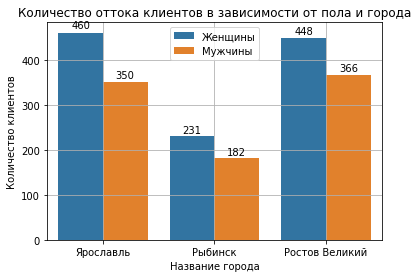

In [ ]:
#выведем график зависимости Количество оттока  клиентов в зависимости от пола и города
sns.countplot(x = 'city', hue = 'gender', data = data_churn)
ax = plt.gca()
autolabel(ax.patches,  height_factor=1.01)
plt.title('Количество оттока клиентов в зависимости от пола и города' )
plt.ylabel('Количество клиентов')
plt.xlabel('Название города')
plt.legend(['Женщины', 'Мужчины'])
plt.grid(True)
    
plt.show()

In [ ]:
#выведем число ушедших женщин клиентов в городе Ярославле
print('Количество ушедших женщин клиентов в городе Ярославле: ',data_churn.\
      query('gender == "Ж" and city=="Ярославль"')['userid'].nunique())

Количество ушедших женщин клиентов в городе Ярославле:  460


In [ ]:
#посмотрим процент ушедших женщин клиентов в городе Ярославле
print('Процент ушедших женщин клиентов в городе Ярославле от общего числа клиентов:', round(data_churn.\
                              query('gender == "Ж" and city=="Ярославль"')['userid'].nunique()
                                        /len(data_churn.query('city=="Ярославль"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов в городе Ярославле от общего числа клиентов: 56.7901 %


In [ ]:
#выведем число ушедших мужчин клиентов в городе Ярославле
print('Количество ушедших мужчин клиентов в городе Ярославле: ',data_churn.\
      query('gender == "М" and city=="Ярославль"')['userid'].nunique())

Количество ушедших мужчин клиентов в городе Ярославле:  350


In [ ]:
#посмотрим процент ушедших мужчин клиентов в городе Ярославле
print('Процент ушедших мужчин клиентов в городе Ярославле от общего числа клиентов:', round(data_churn.\
                              query('gender == "М" and city=="Ярославль"')['userid'].nunique()
                                        /len(data_churn.query('city=="Ярославль"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов в городе Ярославле от общего числа клиентов: 43.2099 %


In [ ]:
print('Процент ушедших неактивных мужчин клиентов в городе Ярославле от общего числа клиентов:', round(data_churn.\
                              query('gender == "М" and city=="Ярославль" and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('city=="Ярославль"')['userid'])*100, 4), '%')

Процент ушедших неактивных мужчин клиентов в городе Ярославле от общего числа клиентов: 27.6543 %


In [ ]:
#посмотрим процент ушедших неактивных  клиентов в городе Ярославле
print('Процент ушедших неактивных клиентов в городе Ярославле от общего числа клиентов:', round(data_churn.\
                              query(' city=="Ярославль" and loyalty==0')['userid'].nunique()
                                        /len(data_churn.query('city=="Ярославль"')['userid'])*100, 4), '%')

Процент ушедших неактивных клиентов в городе Ярославле от общего числа клиентов: 63.2099 %


In [ ]:
#выведем число ушедших неактивных клиентов в городе Ярославле
print('Количество ушедших неактивных клиентов в городе Ярославле: ',data_churn.\
      query(' loyalty==0 and city=="Ярославль"')['userid'].nunique())

Количество ушедших неактивных клиентов в городе Ярославле:  512


In [ ]:
#выведем число ушедших женщин клиентов в городе Ростов Великий
print('Количество ушедших женщин клиентов в городе Ростов Великий: ',data_churn.\
      query('gender == "Ж" and city=="Ростов Великий"')['userid'].nunique())

Количество ушедших женщин клиентов в городе Ростов Великий:  448


In [ ]:
#посмотрим процент ушедших женщин клиентов в городе Ростов Великий
print('Процент ушедших женщин клиентов в городе Ростов Великий от общего числа клиентов:', round(data_churn.\
                              query('gender == "Ж" and city=="Ростов Великий"')['userid'].nunique()
                                        /len(data_churn.query('city=="Ростов Великий"')['userid'])*100, 4), '%')

Процент ушедших женщин клиентов в городе Ростов Великий от общего числа клиентов: 55.0369 %


In [ ]:
#выведем число ушедших мужчин клиентов в городе Ростов Великий
print('Количество ушедших мужчин клиентов в городе Ростов Великий: ',data_churn.\
      query('gender == "М" and city=="Ростов Великий"')['userid'].nunique())

Количество ушедших мужчин клиентов в городе Ростов Великий:  366


In [ ]:
#посмотрим процент ушедших мужчин клиентов в городе Ростов Великий
print('Процент ушедших мужчин клиентов в городе Ростов Великий от общего числа клиентов:', round(data_churn.\
                              query('gender == "М" and city=="Ростов Великий"')['userid'].nunique()
                                        /len(data_churn.query('city=="Ростов Великий"')['userid'])*100, 4), '%')

Процент ушедших мужчин клиентов в городе Ростов Великий от общего числа клиентов: 44.9631 %


In [ ]:
#выведем число ушедших неактивных клиентов в городе Ростов Великий
print('Количество ушедших неактивных клиентов в городе Ростов Великий: ',data_churn.\
      query('loyalty==0 and city=="Ростов Великий"')['userid'].nunique())

Количество ушедших неактивных клиентов в городе Ростов Великий:  518


In [ ]:
#посмотрим процент ушедших неактивных клиентов в городе Ростов Великий
print('Процент ушедших неактивных клиентов в городе Ростов Великий от общего числа клиентов:', round(data_churn.\
                              query('loyalty==0 and city=="Ростов Великий"')['userid'].nunique()
                                        /len(data_churn.query('city=="Ростов Великий"')['userid'])*100, 4), '%')

Процент ушедших неактивных клиентов в городе Ростов Великий от общего числа клиентов: 63.6364 %


По **графику зависимости Количество оттока  клиентов в зависимости от пола и города** отметим, что больше всего клиентов ушло клиента из города Ростов Великий. 

    - Количество ушедших женщин клиентов в городе Ростов Великий:  448 (от общего числа ушедших клиентов в этом городе: 55.0369 %).
    - Количество ушедших мужчин клиентов в городе Ростов Великий:  366 (от общего числа ушедших клиентов в этом городе 44.9631 %)

На втором месте по частоте ухода город Ярославль. 

    - Количество ушедших женщин клиентов в городе Ярославле:  460 (от общего числа ушедших клиентов в этом городе: 56.7901 %). 
    - Количество ушедших мужчин клиентов в городе Ярославле:  350 (от общего числа ушедших клиентов в этом городе:43.2099 %)

Проведя дополнительные вычисления, получили:

    - Количество ушедших неактивных клиентов в городе Ярославле:  512 (63.2099 %)
    - Количество ушедших неактивных клиентов в городе Ростов Великий:  518 (63.6364 %)

**Вывод:**
Портреты клиентов, которые склонны уходить из банка. Женщины уходят чаще мужчин, поэтому разделим по половому признаку:
   - **это Женщина**,
   - Количество ушедших неактивных женщин клиентов:  725 (63.6523 %)
   - Количество ушедших женщин клиентов в возрасте 38-51:  556 это (48.8147 %),
   - Количество ушедших женщин клиентов в городе Ярославле:  460 (от общего числа ушедших клиентов в этом городе: 56.7901 %).
   - Количество ушедших женщин клиентов в городе Ростов Великий:  448 (от общего числа ушедших клиентов в этом городе: 55.0369 %)
   - Количество ушедших женщин клиентов с кредитной картой:  795, что составляет 69.7981 %.,
   - Количество ушедших неактивных женщин клиентов с кредитной картой:  523 и это 45.9175 % от общего числа женщин клиентов.
   - Количество ушедших женщин клиентов с 1 продуктом:  762 (66.9008 %)
   - с нулевым количеством собственности, а также с количеством-10,
   - Количество ушедших женщин клиентов кредитным скорингом 578-716:  587 (51.5364 %),
   - Количество ушедших женщин клиентов с балансом 103701-137987:  415 (36.4355 %).,
   - Количество ушедших женщин клиентов с заработной платой 110 000 - 200 000:  551 (48.3758 %).
   - Количество ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 000:  424 (37.2256 %)
   
   
   - **это Мужчина**,
   - Количество ушедших неактивных мужчин клиентов:  577 (64.2539 %)
   - Количество ушедших мужчин клиентов в возрасте 38-51:  456 (50.7795 %)
   - Количество ушедших мужчин клиентов в городе Ростов Великий:  366 (от общего числа ушедших клиентов в этом городе 44.9631 %)
   - Количество ушедших мужчин клиентов в городе Ярославле:  350 (от общего числа ушедших клиентов в этом городе:43.2099 %)
   - Количество ушедших неактивных мужчин клиентов с кредитной картой:  419 и это 46.6592 % от общего числа мужчин клиентов.
   - количество ушедших мужчин клиентов с кредитной картой:  629, что составляет 70.0445 %
   - Количество ушедших мужчин клиентов с 1 продуктом:  647 (72.049 %),
   - с нулевым количеством собственности, а также с количеством-10,
   - Количество ушедших мужчин клиентов с балансом 103701-137987:  353 (39.3096 %),
   - Количество ушедших мужчин клиентов с заработной платой 20 000 - 120 000:  470 (52.3385 %). 
   - Количество ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 000:  356 (39.6437 %)
   
    **Клиенты**
    - Количество ушедших неактивных клиентов в городе Ярославле:  512 (63.2099 %)
    - Количество ушедших неактивных клиентов в городе Ростов Великий:  518 (63.6364 %)
    - Количество ушедших клиентов с кредитной картой и с балансом 103701-137987:  551 (27.0496 %)
    - Количество ушедших неативных клиентов с заработной платой 110 000 - 200 000:  604 (29.6514 %)
    - Количество ушедших клиентов  с кредитной картой и с кредитным скорингом 578-716:  719 (35.297 %)
    - Количество ушедших неактивных клиентов в возрасте 38-51:  655 (32.1551 %)
    - Количество ушедших  клиентов с одним продуктом в возрасте 38-51:  699 (34.3152 %)

## Шаг. Проверка гипотез
### Формулировка и проверка гипотез 

Будем проверять нашу гипотезу при помощи теста Манна-Уитни, т.к у нас почти одинаковые формы распределения.

Сформулируем гипотезы:

 **Ho**: Между группами "ушел" и "остался" нет статистически значимого различия доходов

 **H1**: Между группами есть статистически значимое различие доходов

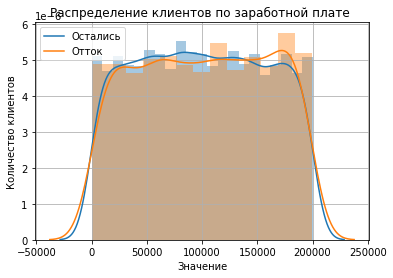

In [ ]:
#выеведем график Распределение клиентов по заработной плате
sns.distplot(data_not_churn['estimated_salary'])
sns.distplot(data_churn['estimated_salary'])
plt.title('Распределение клиентов по заработной плате ')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
plt.legend(['Остались', 'Отток'])
plt.grid(True)

plt.show()

По **графику Распределение клиентов по заработной плате** видно, что  при некоторых значениях заработной платы больше ушедших клиентов, например при 170 000- 200 000, и 110 000 приблизительно. в остальных незначительные отличия в количестве клиентов, при некоторых даже больше на немнго оставшихся: от 70 000 до 100 000.

In [ ]:
print('Дисперсия выборки не ушедших по балансу скоринга = ', round(np.var(data_not_churn['estimated_salary']),2))
print('Дисперсия выборки ушедших по балансу скоринга = ', round(np.var(data_churn['estimated_salary']),2))

Дисперсия выборки не ушедших по балансу скоринга =  3294987575.74
Дисперсия выборки ушедших по балансу скоринга =  3352201702.32


Дисперсии выборок ушедших и не ушедших по бзаработной плате немного различаются. Распределение заработной платы не походит на нормальное распределение. Поэтому вместо t-критерия Стьюдента будем использовать аналогичный методы U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

In [ ]:

ALPHA = .05
def mannwhit (data1, data2, alpha):
    '''
    Для заданных двух групп и ур.знач. alpha проводит тест Манна-Уитни 
    для установления статистического различия между данными
    '''
    print(f'Уровень значимости теста = {alpha}')
    p_v = st.mannwhitneyu(data1, data2).pvalue
    
    print("pvalue = {0:.15f}".format(p_v))
    if (p_v < alpha):
        print('Статистически значимая разница')
    else:
        print('Нет статистически значимой разницы')

mannwhit(data_churn['estimated_salary'], data_not_churn['estimated_salary'], ALPHA)        



Уровень значимости теста = 0.05
pvalue = 0.227051509301538
Нет статистически значимой разницы



Видим, что получили довольно высокое p-значение, которое не позволило нам отвергнуть нуль-гипотезу при 5% уровне значимости.

Таким образом, мы **не в праве** утверждать, что **между группами ушедших и оставшихся клиентов есть статистически значимые различия доходов.**


### Формулировка и проверка дополнительных гипотез



Проверим гипотезу о равенстве баллов скоринга между теми клиентами, которые ушли и теми, которые остались.

  **Ho**: баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, равны
  
  **H1**:баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, различны

Критический уровень статистической значимости зададим значением 0.05.


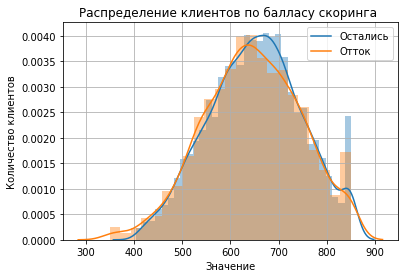

In [ ]:
#выеведем график Распределение клиентов по балласу скоринга 
sns.distplot(data_not_churn['score'])
sns.distplot(data_churn['score'])
plt.title('Распределение клиентов по балласу скоринга ')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
plt.legend(['Остались', 'Отток'])
plt.grid(True)

plt.show()

In [ ]:
print('Дисперсия выборки не ушедших по балансу скоринга = ', round(np.var(data_not_churn['score']),2))
print('Дисперсия выборки ушедших по балансу скоринга = ', round(np.var(data_churn['score']),2))

Дисперсия выборки не ушедших по балансу скоринга =  9148.51
Дисперсия выборки ушедших по балансу скоринга =  10059.46


Дисперсии выборок ушедших и не ушедших по балансу скорига различаются. Распределение доходов является непрерывным, но не походит на нормальное распределение из-за выброса в районе 850 баллов. Поэтому вместо t-критерия Стьюдента будем использовать аналогичный методы U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

In [ ]:
ALPHA = .05
def mannwhit (data1, data2, alpha):
    '''
    Для заданных двух групп и ур.знач. alpha проводит тест Манна-Уитни 
    для установления статистического различия между данными
    '''
    print(f'Уровень значимости теста = {alpha}')
    p_v = st.mannwhitneyu(data1, data2).pvalue
    
    print("pvalue = {0:.15f}".format(p_v))
    if (p_v < alpha):
        print('Статистически значимая разница')
    else:
        print('Нет статистически значимой разницы')
        
mannwhit(data_churn['score'], data_not_churn['score'], ALPHA) 

Уровень значимости теста = 0.05
pvalue = 0.019868661172728
Статистически значимая разница


Т.е. подтвердилась гипотеза **H1**:баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, различны.

## Шаг. Выводы

Обратился менеджер маркетингового отдела, который работает в тесной связке с менеджерами продуктов. Попросил максимально выделить сегменты отточных клиентов банка.

**Задача:**

Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Колонки:**


    userid — идентификатор пользователя,
    score — баллы кредитного скоринга,
    City — город,
    Gender — пол,
    Age — возраст,
    Objects — количество объектов в собственности,
    Balance — баланс на счёте,
    Products — количество продуктов, которыми пользуется клиент,
    CreditCard — есть ли кредитная карта,
    Loyalty — был ли активнен клиент последнее время,
    estimated_salary — заработная плата клиента,
    Churn — ушёл или нет.
    
При знакомстве с датасетом отметили, что количество дубликатов - 0, доля пропусков в Балансе составляет 36.2%. Заполнение данных приведет к искажению, поэтому оставили все как есть.

Максимальное количество **баллов кредитного скоринга** - 850, минимальное - 350,
Минимальный **возраст** -18, а максимальный - 92, средний возраст - 39, 75% клиетов -44,
Минимальное **количество объектов в собственности** - 0, а максимальное - 10,
Минимальный **баланс на счёте** составляет-3769, Максимальный баланс -250 898,
Минимальное **количество продуктов, которыми пользуется клиент** -1, максимальное -4,
Минимальная **заработная плата клиента**-12, максимальная - 199992,
Клиенты бывают разные, разного возраста, с разным числом собственности, кредитной историей и заработной платой.

В датасете 3 города: Ярославль, Рыбинск, Ростов Великий. В Ярославле - 5014 клиентов, в Рыбинске - 2509 клиентов, в Ростове Великом - 2477.

По **Гистограмме распределения  баллов кредитного скоринга** увидели, что большинство клиентов имеют значения баллов кредитного скоринга от 600 до 700, при максимуме значений 850 и минимуме-350.

В датасете 5457 (54,6%) клиентов мужского пола и 4543(45,4%) - женского, почти поровну.

По **Гистограмме распределения  возраста клиентов** отметили, что большое количество клиентов от 25 до 50, с пиком где-то от 32 до 40 лет.

По **Гистограмме  распределения числа объектов клиентов** увидели, что число клиентов распределилось приблизительно одинаково в диапазоне от 1 до 9 объектов, а в два раза меньше клиентов с числом объектов - 0 и 10.

По **Гистограмме распределения  баланса клиентов** отметили, что основная масса клиентов имееет баланс от 51 000 до 180 000, с пиком от 100 000 до 150 000.

По **Диаграмме распределения доли клиентов по наличию кредитных карт банка** увидели, что у 70,6% - есть, у 29,4%-нет.

По **Диаграмме распределения долей клиентов по продуктам банка** отметили, что больше половины клиентов - 50,8% (5084) имеют только один продукт банка, 45,9% (4590) - два продукта банка, 2,7% (266) - три продукта банка, 0,6% (60) - четыре продукта банка.

Почти поровну клиентов активных и не активных. Активных немного больше - 5151, не активных - 4849.

По **Гистограмме распределения  оценочной заработной платы клиентов** заметили, что число клиентов приблизительно одинаково распределяется для всех чисел заработной платы.

Уходят 2037 (20,4%) клиентов, осталось - 7963 (79,6%).

На этапе **Исследования доли оттока для каждого из признаков** обнаружили, что  из числа пропусков в колонке баланс 500 человек приходится на клиентов,которые ушли, и 3117 -которые остались.

Пропуски в балансе  чаще встречаются у клиентов с кредитной картой. Большинство пропусков в балансе для клиентов, пользующихся 2 продуктами банка. Возможно, речь идет о клиентах, использующих только кредитные продукты и не держащих собственных средств на дебетовом счете. В таком случае у клиента как раз могут быть два продукта: например, ипотека и кредитая карта.

В любом случае, без уточняющей информации мы все же не можем заполнять или удалять эти пропуски в колонке баланс.

**На тепловой карте выше представлена матрица значимости** одних параметров по отношению к другим. Видно, что отток клиентов зависит от количества продуктов у клиента банка (0,57),  возраста (0,49). Слабее выражена значимость активности клиента (0,24)

По гистограмме доли оттока клиентов в зависимости от **кредитной карты** увидели, что клиенты у которых кредитная карта этого банка имеется, уходят чаще, чем которые не имееют ее.

По гистограмме доли оттока клиентов в зависимости от **loyalty-был ли клиент активен** отметметили, что те, кто не был активен последнее время, чаще уходят из клиентов банка.

По гистограмме доли оттока клиентов в зависимости от **Гендерного признака** увидли, что женщины уходят чаще, чм мужчины.

По гистограмме доли оттока клиентов в зависимости от **колчества объектов** заметили, что те, у кого количество собственности от 1 до 9 реже уходят, большая доля оттока клиентов с нулевым количеством собственности, а также с количеством-10.

По гистограмме доли оттока клиентов в зависимости от **количества продуктов банка** увидели, что клиенты у которых 3-4 продукта ушло больше, чем осталось, но большее количество уходят клиентов, у которых 1 продукт банка. Самые постоянные клиенты с 2 продуктами, у них отток меньше всего.

По гистограмме доли оттока клиентов в зависимости от **города** отметили, что больше всего отток происходит в городе Ростов Великий, чуть меньше в городе Рыбинск, у остальных меньшая доля клиентов уходит.

По графику  оттока клиентов в зависимости от **score-баллов кредитного скоринга** увидели, что чаще всего клиенты уходят с меньшим числом баллов, особенно от 300 до 450, такая зависимость видна с пиком где-то около 646.

По графику  оттока клиентов в зависимости от **возраста** отметметили, что чаще всего остаются клиенты от 18 до 50, с пиком в 36 лет. А у клиентов которые ушли возраст смещен до 70 где то, с пиком 45 лет.

По графику  оттока клиентов в зависимости от **заработной платы** увидели, что отток больше у клиентов с заработной платой  от 150 000 до 200 000

По графику  оттока клиентов в зависимости от **баланса** заметили, что уходят чаще клиенты, у которых на счету от 100 000 до 150 000, с пиком в 119948


*Далее разбили исследование по гендерному признаку и проанализировали отток в зависимости от других признаков*.


Портреты клиентов, которые склонны уходить из банка. Женщины уходят чаще мужчин, поэтому разделим по половому признаку:
   - **это Женщина**,
   - Количество ушедших неактивных женщин клиентов:  725 (63.6523 %)
   - Количество ушедших женщин клиентов в возрасте 38-51:  556 это (48.8147 %),
   - Количество ушедших женщин клиентов в городе Ярославле:  460 (от общего числа ушедших клиентов в этом городе: 56.7901 %).
   - Количество ушедших женщин клиентов в городе Ростов Великий:  448 (от общего числа ушедших клиентов в этом городе: 55.0369 %)
   - Количество ушедших женщин клиентов с кредитной картой:  795, что составляет 69.7981 %.,
   - Количество ушедших неактивных женщин клиентов с кредитной картой:  523 и это 45.9175 % от общего числа женщин клиентов.
   - Количество ушедших женщин клиентов с 1 продуктом:  762 (66.9008 %)
   - с нулевым количеством собственности, а также с количеством-10,
   - Количество ушедших женщин клиентов кредитным скорингом 578-716:  587 (51.5364 %),
   - Количество ушедших женщин клиентов с балансом 103701-137987:  415 (36.4355 %).,
   - Количество ушедших женщин клиентов с заработной платой 110 000 - 200 000:  551 (48.3758 %).
   - Количество ушедших женщин клиентов с кредитной картой с заработной платой 0 - 110 000:  424 (37.2256 %)
   
   
   - **это Мужчина**,
   - Количество ушедших неактивных мужчин клиентов:  577 (64.2539 %)
   - Количество ушедших мужчин клиентов в возрасте 38-51:  456 (50.7795 %)
   - Количество ушедших мужчин клиентов в городе Ростов Великий:  366 (от общего числа ушедших клиентов в этом городе 44.9631 %)
   - Количество ушедших мужчин клиентов в городе Ярославле:  350 (от общего числа ушедших клиентов в этом городе:43.2099 %)
   - Количество ушедших неактивных мужчин клиентов с кредитной картой:  419 и это 46.6592 % от общего числа мужчин клиентов.
   - количество ушедших мужчин клиентов с кредитной картой:  629, что составляет 70.0445 %
   - Количество ушедших мужчин клиентов с 1 продуктом:  647 (72.049 %),
   - с нулевым количеством собственности, а также с количеством-10,
   - Количество ушедших мужчин клиентов с балансом 103701-137987:  353 (39.3096 %),
   - Количество ушедших мужчин клиентов с заработной платой 20 000 - 120 000:  470 (52.3385 %). 
   - Количество ушедших мужчин клиентов с кредитной картой с заработной платой 0 - 110 000:  356 (39.6437 %)
   
    **Клиенты**
    - Количество ушедших неактивных клиентов в городе Ярославле:  512 (63.2099 %)
    - Количество ушедших неактивных клиентов в городе Ростов Великий:  518 (63.6364 %)
    - Количество ушедших клиентов с кредитной картой и с балансом 103701-137987:  551 (27.0496 %)
    - Количество ушедших неативных клиентов с заработной платой 110 000 - 200 000:  604 (29.6514 %)
    - Количество ушедших клиентов  с кредитной картой и с кредитным скорингом 578-716:  719 (35.297 %)
    - Количество ушедших неактивных клиентов в возрасте 38-51:  655 (32.1551 %)
    - Количество ушедших  клиентов с одним продуктом в возрасте 38-51:  699 (34.3152 %)
   
Также проверили наши гипотезы  при помощи теста Манна-Уитни, т.к у нас почти одинаковые формы распределения.

 **Ho**: Между группами "ушел" и "остался" нет статистически значимого различия доходов

 **H1**: Между группами есть статистически значимое различие доходов
 
Получили довольно высокое p-значение, которое не позволило нам отвергнуть нуль-гипотезу при 5% уровне значимости.

Таким образом, мы **не в праве** утверждать, что **между группами ушедших и оставшихся клиентов есть статистически значимые различия доходов.**


Проверили гипотезу о равенстве баллов скоринга между теми клиентами, которые ушли и теми, которые остались.

  **Ho**: баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, равны
  **H1**:баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, различны
  
Получилось, что баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались имеют статистически значимую разницу.


**Рекомендации:**

Предлагать продукты банка клиентам, у которых один продукт банка, и повышать активность клиента   в возрастной категории от 38 лет до 51 лет, проживающих особенно в Ростов Великий, можно и в Ярославле, акцент сделать на женщинах, не имеющих кредитных карт, с балансом от 103701-137987, значением заработной платы от 110 000 до 200 000. Также предлагать удобные условия и для женщин и мужчин с кредитной картой с заработной платой 0 - 110 000.  Клиенты, у которых 2 продукта банка, уходят реже.

## Презентация 

**Презентация:** <https://disk.yandex.ru/i/JRtC5hQiEOc-qA>



# Анализ базы данных при помощи SQL

**Цель исследования - проанализировать базу данных, состоящую из книг, авторов, издателей, а также пользовательские обзоры книг и на их основе сформулировать ценностное предложение для нового продукта.
Описание данных**

*Таблица books*

Содержит данные о книгах:

    book_id — идентификатор книги;
    author_id — идентификатор автора;
    title — название книги;
    num_pages — количество страниц;
    publication_date — дата публикации книги;
    publisher_id — идентификатор издателя.

*Таблица authors*

Содержит данные об авторах:

    author_id — идентификатор автора;
    author — имя автора.

*Таблица publishers*

Содержит данные об издательствах:

    publisher_id — идентификатор издательства;
    publisher — название издательства;

*Таблица ratings*

Содержит данные о пользовательских оценках книг:

    rating_id — идентификатор оценки;
    book_id — идентификатор книги;
    username — имя пользователя, оставившего оценку;
    rating — оценка книги.

*Таблица reviews*

Содержит данные о пользовательских обзорах на книги:

    review_id — идентификатор обзора;
    book_id — идентификатор книги;
    username — имя пользователя, написавшего обзор;
    text — текст обзора.

**Задания**

    Посчитайте, сколько книг вышло после 1 января 2000 года;
    Для каждой книги посчитайте количество обзоров и среднюю оценку;
    Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры;
    Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками;
    Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок.



## Изучение таблиц

In [ ]:
# импортируем библиотеки
import pandas as pd 
from sqlalchemy import create_engine 

In [ ]:
# устанавливаем параметры

db_config = {'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', 
'port': 6432, # порт подключения
'db': 'data-analyst-final-project-db'} # название базы данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'], 
 db_config['pwd'], 
 db_config['host'], 
 db_config['port'], 
 db_config['db']) 

# сохраняем коннектор

engine = create_engine(connection_string, connect_args={'sslmode':'require'})

### Таблица books 

In [ ]:
#выведем все столбцы таблицы
query = '''
            SELECT * 
            FROM books
        '''
books = pd.io.sql.read_sql(query, con = engine)
books.head()

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


In [ ]:
#выведем общую информацию о таблице
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_id           1000 non-null   int64 
 1   author_id         1000 non-null   int64 
 2   title             1000 non-null   object
 3   num_pages         1000 non-null   int64 
 4   publication_date  1000 non-null   object
 5   publisher_id      1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


### Таблица authors 

In [ ]:
#выведем все столбцы таблицы
query = '''
            SELECT * 
            FROM authors
        '''
authors = pd.io.sql.read_sql(query, con = engine)
authors.head()

,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


In [ ]:
#выведем общую информацию о таблице
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  636 non-null    int64 
 1   author     636 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


### Таблица publishers

In [ ]:
#выведем все столбцы таблицы
query = '''
            SELECT * 
            FROM publishers
        '''
publishers = pd.io.sql.read_sql(query, con = engine)
publishers.head()

,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


In [ ]:
#выведем общую информацию о таблице
publishers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher_id  340 non-null    int64 
 1   publisher     340 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


### Таблица ratings 

In [ ]:
#выведем все столбцы таблицы
query = '''
            SELECT * 
            FROM ratings
        '''
ratings = pd.io.sql.read_sql(query, con = engine)
ratings.head()

,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


In [ ]:
#выведем общую информацию о таблице
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating_id  6456 non-null   int64 
 1   book_id    6456 non-null   int64 
 2   username   6456 non-null   object
 3   rating     6456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 201.9+ KB


### Таблица reviews

In [ ]:
#выведем все столбцы таблицы
query = '''
            SELECT * 
            FROM reviews
        '''
reviews = pd.io.sql.read_sql(query, con = engine)
reviews.head()

,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...


In [ ]:
#выведем общую информацию о таблице
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  2793 non-null   int64 
 1   book_id    2793 non-null   int64 
 2   username   2793 non-null   object
 3   text       2793 non-null   object
dtypes: int64(2), object(2)
memory usage: 87.4+ KB


## Ответы на вопросы

### Сколько книг вышло после 1 января 2000 года?

In [ ]:
#выведем число книг 
query = '''
            SELECT COUNT(book_id) count_of_books
            FROM books 
            WHERE publication_date > '01-01-2000'
        '''
pd.io.sql.read_sql(query, con = engine)

,count_of_books
0,819


**Ответ:**
После 1 января 2000 года было выпущено 819 книг.


### Для каждой книги посчитайте количество обзоров и среднюю оценку

In [ ]:
#выведем таблицу книг с числом обзоров и среднюю оценку
query = '''
            SELECT b.title AS book_name, b.book_id, rat.avg_rating, rev.review_count
            FROM books b
            LEFT JOIN (
                    SELECT book_id, AVG(rating) avg_rating 
                    FROM ratings 
                    GROUP BY book_id) rat ON b.book_id=rat.book_id
            LEFT JOIN (
                    SELECT book_id, COUNT(*) review_count 
                    FROM reviews 
                    GROUP BY book_id) rev ON b.book_id=rev.book_id
        '''
pd.io.sql.read_sql(query, con = engine)

,book_name,book_id,avg_rating,review_count
0,The Body in the Library (Miss Marple #3),652,4.500000,2.0
1,Galápagos,273,4.500000,2.0
2,A Tree Grows in Brooklyn,51,4.250000,5.0
3,Undaunted Courage: The Pioneering First Missio...,951,4.000000,2.0
4,The Prophet,839,4.285714,4.0
...,...,...,...,...
995,Alice in Wonderland,64,4.230769,4.0
996,A Woman of Substance (Emma Harte Saga #1),55,5.000000,2.0
997,Christine,148,3.428571,3.0
998,The Magicians' Guild (Black Magician Trilogy #1),790,3.500000,2.0


**Ответ:** для большинства книг было написано несколько обзоров и средние оценки варьируются.

### Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры

In [ ]:
#выведем число книг
query = '''
            SELECT b.publisher_id, p.publisher, COUNT(*) count_books
            FROM books b
            LEFT JOIN publishers p ON b.publisher_id = p.publisher_id
            WHERE num_pages > 50
            GROUP BY b.publisher_id, p.publisher
            ORDER BY COUNT(*) DESC
            LIMIT 1
        '''
pd.io.sql.read_sql(query, con = engine)

,publisher_id,publisher,count_books
0,212,Penguin Books,42


**Ответ:** Издательство "Penguin Books" выпустило 42 книги толще 50 страниц. Это около 4% от всех книг в датасете.

### Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками

In [ ]:
#выведем  автора и рейтинг
query = '''
SELECT
    authors.author AS автор,
    AVG(ratings.rating) AS средний_рейтинг
    FROM ratings
    JOIN books ON books.book_id = ratings.book_id
    JOIN authors ON books.author_id = authors.author_id
    WHERE ratings.book_id IN (
          SELECT ratings.book_id
          FROM ratings
          GROUP BY ratings.book_id
          HAVING COUNT(ratings.book_id) >= 50)
    GROUP BY authors.author_id
    ORDER BY AVG(ratings.rating) DESC
    LIMIT 1'''
data = pd.io.sql.read_sql(query, con = engine)
data

,автор,средний_рейтинг
0,J.K. Rowling/Mary GrandPré,4.287097


**Ответ:** Самую высокую оценку у книг с 50 и более оценками занимает - J.K. Rowling/Mary GrandPré - 4.283844. Джоан Роулинг, автор книг о Гарри Поттере.В данной задаче указана в соавторстве с Мэри Гранпрэ(иллюстратором).

### Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок

In [ ]:
query = '''

  SELECT AVG (reviews_count) as avg_reviews_count
  FROM ( 
        SELECT username,
        COUNT(review_id) as reviews_count
        FROM reviews
        GROUP BY username
        HAVING username IN (
                            SELECT username
                            FROM ratings
                            GROUP BY username
                            HAVING COUNT (rating_id) > 50
                            )
                            
                            
        ) as reviews
  
  '''
pd.io.sql.read_sql(query, con = engine)

,avg_reviews_count
0,24.333333


**Ответ:** Читатели, которые поставили больше 50 оценок, в среднем пишут по 24 обзора

# Вывод

В нашем распоряжении было 5 таблиц:

    books - содержит 1000 строк и 6 столбцов, содержит данные о книгах;
    authors - содержит 636 строк и 2 столбца, содержит данные об авторах;
    publishers - содержит 340 строк, 2 столбца, содержит данные об издательствах;
    rating - содержит 6456 строк, 4 столбца, содержит данные о пользовательских обзорах;
    reviews - содержит 2793 строки, 4 столбца, содержит данные о пользовательских обзорах.

**В ходе работы были даны ответы на 5 поставленных вопросов:**

*1. Cколько книг вышло после 1 января 2000 года?* 
    
**Ответ:** с 1 января 2000 года, в базе хранится информация о 819 книгах

*2. Для каждой книги посчитайте количество обзоров и среднюю оценку*

**Ответ:** для большинства книг было написано несколько обзоров и средние оценки варьируются.

*3. Определить издательство, которое выпустило наибольшее число книг толще 50 страниц — таким образом исключим из анализа брошюры.*

**Ответ:** Издательство "Penguin Books" выпустило 42 книги толще 50 страниц. Это около 4% от всех книг в данных. 

*3. Определить автора с самой высокой средней оценкой книг — учитывать только книги с 50 и более оценками.* 

**Ответ:** Самую высокую оценку у книг с 50 и более оценками занимает - J.K. Rowling/Mary GrandPré - 4.283844. Джоан Роулинг, автор книг о Гарри Поттере.В данной задаче указана в соавторстве с Мэри Гранпрэ(иллюстратором).

*4. Посчитать среднее количество обзоров от пользователей, которые поставили больше 50 оценок.*

**Ответ:** Читатели, которые поставили больше 50 оценок, в среднем пишут по 24 обзора